**извлечение признаков из текста на естественном языке**

классификатор текстов HashingVectorizer

_Евгений Борисов <esborisov@sevsu.ru>_

## библиотеки

In [1]:
import re
# import gzip
import numpy as np
import numpy.random as rng
import pandas as pd
from tqdm.notebook import tqdm

np.set_printoptions(precision=2) # вывод на печать чисел до 2 знака
pd.options.display.max_colwidth = 200 

tqdm.pandas()

In [2]:
# import numpy as np
# import pandas as pd
# import re

In [3]:
from sklearn import __version__ as SKLEARN_VERSION

from sklearn.feature_extraction.text import HashingVectorizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

SKLEARN_VERSION

'1.0.2'

## тексты

In [4]:
# загружаем тексты
data = pd.read_pickle('../data/news.pkl.gz')
print('записей:',len(data))
data.sample(5)

записей: 3196


,text,tag
1224,В США поезд с кроссоверами BMW сошел с рельсов: повреждено около 120 автомобилей\n\n6 декабря 2016 в 12:35\n\nAUTO.TUT.BY\n\nВ результате схода поезда с рельсов в США повреждены около 120 автомоби...,auto
2829,"17:23 - 12.12.2016\n\nТакже это касается и официальных порталов госорганов, сайтов государственных и муниципальных предприятий.\n\nКак отметили в ведомстве, надзорный орган не будет применять меры...",tech
3054,"Накануне мы рассказали о проблеме жителей поселка Южный. По их словам, оборудование, установленное возле небольшой речки, уже 15 лет загрязняет водоем. Там перестала водиться рыба, вода стала опас...",social
763,"Белорусский ""Фармлэнд"" изымает из обращения лекарственное средство ""Эмоксипин""\n\nопубликовано: 7 декабря 2016 в 10:21\n\nобновлено: 7 декабря 2016 в 18:05\n\nЕжедневник\n\nБелорусский производите...",social
1060,От 5 до 50%. Где минчанам искать скидки в декабре\n\n29 ноября 2016 в 14:39\n\nFINANCE.TUT.BY\n\nСтоличные универмаги и торговые сети в декабре будут часто предоставлять скидки на товары. Об акция...,economics


## токенизация и очистка

In [5]:
# # собираем словарь из текстов
# def get_vocabulary(ds):
#     vcb = [ set(s) for s in ds.tolist() ]
#     return sorted(set.union(*vcb))

In [6]:
# применяет список замен pat к строке s
def replace_patterns(s,pat):
    if len(pat)<1: return s
    return  replace_patterns( re.sub(pat[0][0],pat[0][1],s), pat[1:] )

# нормализация текста
def string_normalizer(s):
    pat = [
       [r'ё','е'] # замена ё для унификации
       ,[r'</?[a-z]+>',' '] # удаляем xml
       ,[r'[^a-zа-я\- ]+',' '] # оставляем только буквы, пробел и -
       ,[r' -\w+',' '] # удаляем '-й','-тый' и т.п.
       ,[r'\w+- ',' ']
       ,[r' +',' '] # удаляем повторы пробелов
    ]
    return replace_patterns(s.lower(),pat).strip()

In [7]:
data['ctext'] = data['text'].progress_apply(string_normalizer)

  0%|          | 0/3196 [00:00<?, ?it/s]

In [8]:
# # разрезаем стоки на слова
# def tokenize(s): return [ w for w in s.split(' ') if (len(w)>1) ]

In [9]:
# vcb =  get_vocabulary( data['ctext'].progress_apply( tokenize ) )
# print('словарь %i слов'%(len(vcb)))
# # pd.DataFrame( vcb ).to_csv('voc.txt',index=False,header=False)

In [10]:
data.sample(5)

,text,tag,ctext
1537,В Москве сотрудниками Главного управления экономической безопасности и противодействия коррупции МВД России совместно с ГУ МВД России по г. Москве при содействии Минздрава России выявлено крупное ...,incident,в москве сотрудниками главного управления экономической безопасности и противодействия коррупции мвд россии совместно с гу мвд россии по г москве при содействии минздрава россии выявлено крупное х...
1885,"Аукционный дом Tajan обнаружил в пачке из 15 рисунков, которые принёс парижский пенсионер, неизвестный эскиз Леонардо да Винчи. Об этом сообщает The Telegraph.\n\nВ ходе экспертиз было установлено...",culture,аукционный дом tajan обнаружил в пачке из рисунков которые принес парижский пенсионер неизвестный эскиз леонардо да винчи об этом сообщает the telegraph в ходе экспертиз было установлено что рисун...
1678,"Заявление первого президента СССР Михаила Горбачева о том, что в границах бывшего Советского Союза может появиться новое государство, — не более чем популизм. Такое мнение в беседе с «Лентой.ру» в...",politics,заявление первого президента ссср михаила горбачева о том что в границах бывшего советского союза может появиться новое государство не более чем популизм такое мнение в беседе с лентой ру высказал...
2057,"Сеск Фабрегас / Фото: © Reuters\n\nПолузащитник лондонского «Челси» Сеск Фабрегас отказался переходить в китайский клуб, предложивший ему годовую зарплату размером в 31 миллион евро.\n\nЧемпион ми...",sport,сеск фабрегас фото reuters полузащитник лондонского челси сеск фабрегас отказался переходить в китайский клуб предложивший ему годовую зарплату размером в миллион евро чемпион мира и европы в сост...
1069,"Sports.ru вычислил медалистов Сочи-2014, которые пили допинговый коктейль Родченкова\n\n10 декабря 2016 в 12:10\n\nАлексей Авдохин, Sports.ru\n\nЕще в интервью The New York Times Григорий Родченко...",sport,sports ru вычислил медалистов которые пили допинговый коктейль родченкова декабря в алексей авдохин sports ru еще в интервью the new york times григорий родченков бывший глава московской лаборатор...


## Vectorizer

In [11]:
%%time 

def tokenizer(s): 
    for w in s.split(' '):
        if (len(w)>1): 
            yield w

tf = HashingVectorizer( n_features=4096, norm='l2', tokenizer=tokenizer,token_pattern=None).fit( data['ctext'] )

CPU times: user 314 µs, sys: 29 µs, total: 343 µs
Wall time: 353 µs


## формируем датасеты

In [12]:
%%time 

X = tf.transform( data['ctext'] )
X.shape

CPU times: user 1.05 s, sys: 12.6 ms, total: 1.07 s
Wall time: 1.14 s


(3196, 4096)

In [13]:
labels = { t:i for i,t in enumerate(sorted(set(data['tag']))) }
labels

{'auto': 0,
 'culture': 1,
 'economics': 2,
 'health': 3,
 'incident': 4,
 'politics': 5,
 'realty': 6,
 'reclama': 7,
 'science': 8,
 'social': 9,
 'sport': 10,
 'tech': 11,
 'woman': 12}

In [14]:
y = data['tag'].map(labels).values
y

array([5, 1, 1, ..., 8, 5, 9])

In [15]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=326 )
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2237, 4096), (2237,), (959, 4096), (959,))

## обучаем классификатор

In [16]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(loss='hinge',max_iter=1000, tol=0.19)
clf.fit(X_train,y_train)

SGDClassifier(tol=0.19)

## тестируем

In [17]:
o = clf.predict(X_train)
accuracy_score(y_train,o)

0.9991059454626732

In [18]:
o = clf.predict(X_test)
accuracy_score(y_test,o)

0.8269030239833159

In [19]:
print( classification_report(y_test,o) )

              precision    recall  f1-score   support

           0       0.93      0.87      0.90        87
           1       0.74      0.85      0.79       101
           2       0.78      0.79      0.78        76
           3       0.81      0.55      0.65        31
           4       0.90      0.89      0.89       123
           5       0.80      0.93      0.86       177
           6       0.58      0.52      0.55        21
           7       1.00      0.59      0.74        17
           8       0.84      0.99      0.91        68
           9       0.62      0.34      0.44        44
          10       0.97      0.96      0.97       118
          11       0.73      0.66      0.69        89
          12       1.00      0.86      0.92         7

    accuracy                           0.83       959
   macro avg       0.82      0.75      0.78       959
weighted avg       0.83      0.83      0.82       959



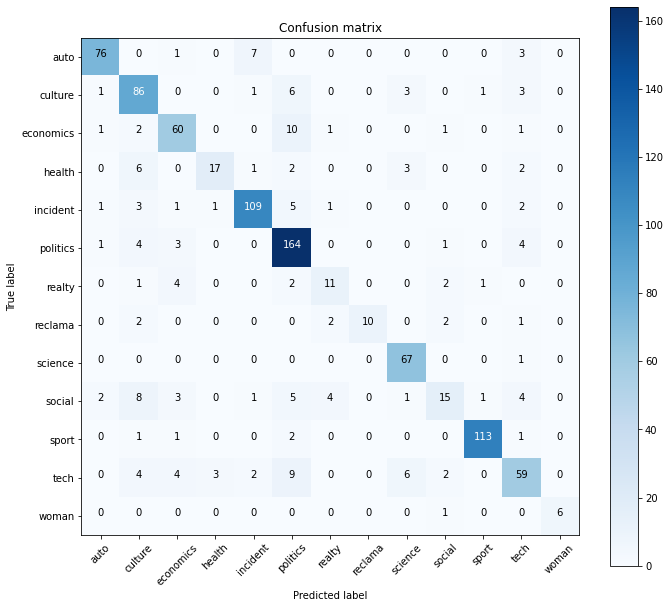

In [20]:
from matplotlib import pyplot as plt
import itertools

classes = sorted(labels.keys())
cm = confusion_matrix(y_test,o)
tick_marks = np.arange(len(classes))

plt.figure(figsize=(10,9))

plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.title('Confusion matrix')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()

plt.show()

---

In [21]:
o = clf.predict(X)

labels_inv = { labels[k]:k for k in labels }

for n in range(10):
    i = rng.randint(len(data))
    print('tag:',data.iloc[i,1])
    print('predict:',labels_inv[o[i]])
    print(re.sub(r'\n\s*\n',' ',data.iloc[i,0][:200])+'...')
    print('- - - - - - - - - - - - - - - - - -')
    

tag: tech
predict: tech
После первого января новостные агрегаторы смогут продолжать использовать материалы СМИ без каких-либо проверок. Роскомнадзор не будет привлекать их к ответственности за недостоверную информацию в заре...
- - - - - - - - - - - - - - - - - -
tag: politics
predict: politics
Президент Венесуэлы Николас Мадуро распорядился на 72 часа закрыть границу с Колумбией, чтобы избежать контрабанды валюты. Об этом сообщает Associated Press. По словам Мадуро, контрабандисты, которых...
- - - - - - - - - - - - - - - - - -
tag: auto
predict: auto
"Оля всегда боялась машин". В Слуцке простились с погибшей под колесами авто пьяного гаишника 28 ноября 2016 в 20:25 Тамара Савич / AUTO.TUT.BY / Фото: Вадим Замировский «Ты сильный, ты же взрослый...
- - - - - - - - - - - - - - - - - -
tag: tech
predict: tech
Новая технология уменьшит количество сотовых башен Корейский оператор
SK Telecom в следующем году планирует построить новую сеть, а точнее
сеть, основанную на новой технологии ante